## Study bearish engulfing on weekly timeframe for NIFTY

In [143]:
import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset

import datetime

import niftyutils
from niftyutils import load_nifty_data

import matplotlib.pyplot as plt

In [144]:
start_date = datetime.datetime(2005,8,1)
end_date = datetime.datetime(2020,8,29)
nifty_data = load_nifty_data(start_date,end_date)

In [145]:
weekly_nifty_data = nifty_data.resample('W').agg(niftyutils.OHLC_CONVERSION_DICT)
weekly_nifty_data.index = weekly_nifty_data.index - to_offset('6D')
weekly_nifty_data.tail(3)

,Open,High,Low,Close,Volume
Date,,,,,
2020-08-10,11270.25,11373.60,11111.45,11178.4,2.895408e+09
2020-08-17,11248.90,11460.35,11144.50,11371.6,3.299731e+09
2020-08-24,11412.00,11686.05,11410.65,11647.6,3.441270e+09


In [146]:
weekly_nifty_data['Pct_Chg'] = (weekly_nifty_data['Close']/weekly_nifty_data['Close'].shift(1) - 1)*100
weekly_nifty_data = weekly_nifty_data.dropna()
weekly_nifty_data.tail(3)

,Open,High,Low,Close,Volume,Pct_Chg
Date,,,,,,
2020-08-10,11270.25,11373.60,11111.45,11178.4,2.895408e+09,-0.317905
2020-08-17,11248.90,11460.35,11144.50,11371.6,3.299731e+09,1.728333
2020-08-24,11412.00,11686.05,11410.65,11647.6,3.441270e+09,2.427099


In [147]:
def find_weak_bearish_engulfing(ohlc_data):
    engulfing_occurence_list = []
    
    for (indx1,row1),(indx2,row2) in zip(ohlc_data[:-1].iterrows(), ohlc_data[1:].iterrows()):
        
        first_pct_change = row1['Pct_Chg']
        second_pct_change = row2['Pct_Chg']
    
        first_open = row1['Open']
        first_close = row1['Close']
        second_open = row2['Open']
        second_close = row2['Close']
        
        if first_pct_change > 0 and second_pct_change < 0 and second_close < second_open:

            first_price_range = np.array([first_open,first_close])
            if second_open > second_close :
                max_boundary = second_open
                min_boundary = second_close
            else:
                max_boundary = second_close
                min_boundary = second_open

            if np.all((first_price_range > min_boundary) & (first_price_range < max_boundary)):
                engulfing_occurence_list.append((indx1,indx2))
        
    return engulfing_occurence_list

In [148]:
find_weak_bearish_engulfing(weekly_nifty_data)[:3]

[(Timestamp('2006-04-03 00:00:00'), Timestamp('2006-04-10 00:00:00')),
 (Timestamp('2006-07-10 00:00:00'), Timestamp('2006-07-17 00:00:00')),
 (Timestamp('2006-11-27 00:00:00'), Timestamp('2006-12-04 00:00:00'))]

In [149]:
def find_full_bearish_engulfing(ohlc_data):
    engulfing_occurence_list = []
    
    for (indx1,row1),(indx2,row2) in zip(ohlc_data[:-1].iterrows(), ohlc_data[1:].iterrows()):
        
        first_pct_change = row1['Pct_Chg']
        second_pct_change = row2['Pct_Chg']
    
        first_high = row1['High']
        first_low = row1['Low']
        second_open = row2['Open']
        second_close = row2['Close']
        
        if first_pct_change > 0 and second_pct_change < 0 and second_close < second_open:

            first_price_range = np.array([first_high,first_low])
            max_boundary = second_open
            min_boundary = second_close
            
            if np.all((first_price_range > min_boundary) & (first_price_range < max_boundary)):
                engulfing_occurence_list.append((indx1,indx2))
        
    return engulfing_occurence_list

In [150]:
full_bearish_engilfing_list = find_full_bearish_engulfing(weekly_nifty_data)
full_bearish_engilfing_list

[(Timestamp('2010-12-27 00:00:00'), Timestamp('2011-01-03 00:00:00')),
 (Timestamp('2013-12-23 00:00:00'), Timestamp('2013-12-30 00:00:00')),
 (Timestamp('2014-06-30 00:00:00'), Timestamp('2014-07-07 00:00:00')),
 (Timestamp('2015-10-19 00:00:00'), Timestamp('2015-10-26 00:00:00')),
 (Timestamp('2017-09-11 00:00:00'), Timestamp('2017-09-18 00:00:00')),
 (Timestamp('2018-05-07 00:00:00'), Timestamp('2018-05-14 00:00:00')),
 (Timestamp('2020-01-13 00:00:00'), Timestamp('2020-01-20 00:00:00'))]

In [151]:
weekly_nifty_data

,Open,High,Low,Close,Volume,Pct_Chg
Date,,,,,,
2005-08-08,2361.95,2390.45,2303.10,2361.55,4.375600e+08,0.014823
2005-08-15,2361.65,2426.65,2356.85,2383.45,2.315300e+08,0.927357
2005-08-22,2383.45,2403.45,2300.45,2357.05,3.075600e+08,-1.107638
2005-08-29,2359.20,2422.10,2312.60,2415.80,2.600600e+08,2.492522
2005-09-05,2417.10,2462.80,2414.95,2455.45,1.916700e+08,1.641278
...,...,...,...,...,...,...
2020-07-27,11225.00,11341.40,11026.65,11073.45,3.193090e+06,-1.078242
2020-08-03,11057.55,11256.80,10882.25,11214.05,3.027312e+09,1.269704
2020-08-10,11270.25,11373.60,11111.45,11178.40,2.895408e+09,-0.317905


In [152]:
event_dates = []
for start_date,end_date in full_bearish_engilfing_list:
    event_dates.append(end_date) 

In [153]:
event_indices = []
event_annotate_text = []
for event_date in event_dates:
    event_indices.append(weekly_nifty_data.index.get_loc(event_date))
    event_annotate_text.append(event_date.strftime('%-d %b, %Y'))

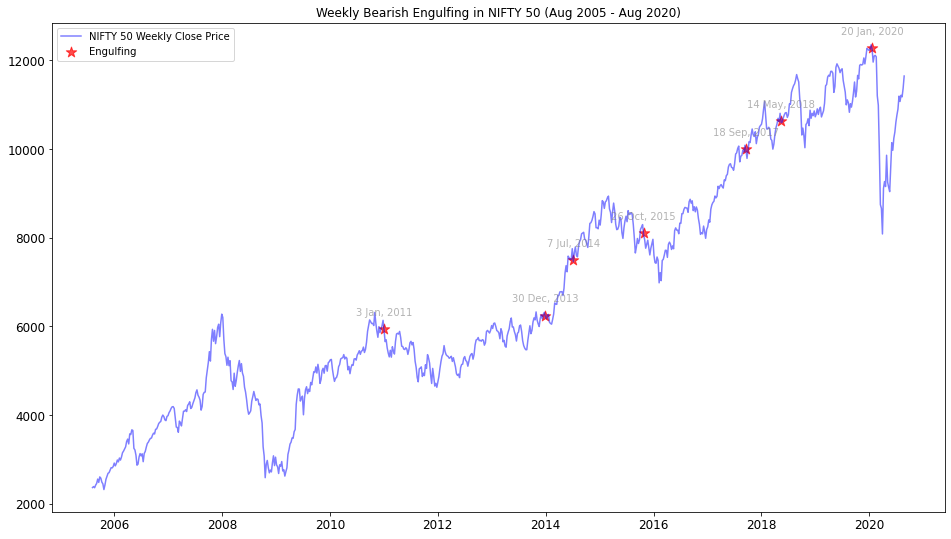

In [154]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot()

y = weekly_nifty_data['Close']
ax.plot(y, color = "blue", alpha = .5, label = "NIFTY 50 Weekly Close Price")

annotate_index_mask = [10,20,30]
ax.scatter(x = y[event_indices].index, y = y[event_indices].values+30, 
           marker = '*', s = 120, color = "red", alpha = .7, label = "Engulfing")

for event_index, annotation_text in zip(event_indices, event_annotate_text):
    ax.text(y.index[event_index], y[event_index] + 300, 
            s = annotation_text, fontsize = 10, horizontalalignment = 'center', verticalalignment = 'bottom', 
            alpha = 0.6, color = 'gray')
    
ax.tick_params(axis = 'x', labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

ax.set_title("Weekly Bearish Engulfing in NIFTY 50 (Aug 2005 - Aug 2020)", fontsize = 12)
ax.legend(loc = "upper left", fontsize = 10);

In [155]:
full_bearish_engilfing_list

[(Timestamp('2010-12-27 00:00:00'), Timestamp('2011-01-03 00:00:00')),
 (Timestamp('2013-12-23 00:00:00'), Timestamp('2013-12-30 00:00:00')),
 (Timestamp('2014-06-30 00:00:00'), Timestamp('2014-07-07 00:00:00')),
 (Timestamp('2015-10-19 00:00:00'), Timestamp('2015-10-26 00:00:00')),
 (Timestamp('2017-09-11 00:00:00'), Timestamp('2017-09-18 00:00:00')),
 (Timestamp('2018-05-07 00:00:00'), Timestamp('2018-05-14 00:00:00')),
 (Timestamp('2020-01-13 00:00:00'), Timestamp('2020-01-20 00:00:00'))]

In [166]:
def calculate_percent_gain(N_data):
    first_open = N_data.iloc[0]['Open']
    last_close = N_data.iloc[-1]['Close']
    percent = ((last_close - first_open)/first_open)*100
    return percent

In [164]:
key_stats_days = [1,2,3,5]
after_engulfing_list = []

for engulfing_ix in event_indices:
    key_days_gain_stats = []
    for days in key_stats_days:
        after_engulfing_data = weekly_nifty_data[engulfing_ix + 1 : engulfing_ix + 1 + days]
        pct_change = calculate_percent_gain(after_engulfing_data)
        key_days_gain_stats.append(pct_change)
    
    after_engulfing_list.append(key_days_gain_stats)

In [165]:
after_engulfing_stats = pd.DataFrame(after_engulfing_list, columns=['after_{}_weeks'.format(i) for i in key_stats_days])
after_engulfing_stats

,after_1_weeks,after_2_weeks,after_3_weeks,after_5_weeks
0,-4.181282,-3.470422,-6.594310,-10.019826
1,-0.794104,0.655859,0.737841,-2.534220
2,2.609452,4.303789,1.788727,4.320525
3,-1.244638,-3.629005,-2.458238,-3.385043
4,-1.721870,0.196785,2.081806,3.644040
5,-0.108791,0.748820,1.421817,1.932333
6,-1.926687,-0.809619,-0.685819,-8.160546


In [171]:
key_stats_days = [1,2,3,5]
before_engulfing_list = []

for engulfing_ix in event_indices:
    key_days_gain_stats = []
    for days in reversed(key_stats_days):
        before_engulfing_data = weekly_nifty_data[engulfing_ix - 1 - days: engulfing_ix - 1]
        pct_change = calculate_percent_gain(before_engulfing_data)
        key_days_gain_stats.append(pct_change)
        
    before_engulfing_list.append(key_days_gain_stats)

In [172]:
before_engulfing_stats = pd.DataFrame(before_engulfing_list, columns=['before_{}_weeks'.format(i) for i in reversed(key_stats_days)])
before_engulfing_stats

,before_5_weeks,before_3_weeks,before_2_weeks,before_1_weeks
0,1.531862,-0.365450,2.192039,1.429933
1,2.670572,1.670677,-2.194076,1.716829
2,1.077570,-1.480651,-0.345066,-0.069204
3,5.467220,4.375507,2.911269,0.080787
4,-1.389606,0.715209,0.279091,-0.494283
5,4.596297,2.115250,0.240258,-0.817318
6,2.661005,0.174493,-0.147455,0.708264


In [175]:
after_engulfing_stats['after_1_weeks'].mean()

-1.0525600187747044